# Kiva Loan Data EDA and Analysis

### About Kiva
Kiva is an international nonprofit founded in 2005 with a mission to connect people through lending to alleviate poverty. In June 2018 Kiva was in 85 countries, and had served 2.9 Million borrowers through $ 1.16 Billion worth of loans.

### How it works
1. A borrower applies for a loan (micro-finance partner, or Kiva directly).
2. The loan goes through the underwriting and approval process.
3. The loan is posted to Kiva for lenders to support, and a 30-day fundraising period begins.
4. Borrowers repay the loans.
* Note that Kiva does not collect interest on loans, and Kiva lenders do not receive interest from loans they support on Kiva. However, Field Partners collect interest from borrowers to cover their operation costs.

### About Kiva's Data
This analysis uses Kiva's Data Snapshot (https://build.kiva.org/docs/data/snapshots) downloaded on June 15th, 2018.

### Objectives of this Notebook
1. Conduct Exploratory Data Analysis
2. Question??

## Libraries and Data

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
%matplotlib inline

In [35]:
df = pd.read_csv('kiva_ds_csv/loans.csv', parse_dates=['POSTED_TIME', 'PLANNED_EXPIRATION_TIME', 'DISBURSE_TIME',
       'RAISED_TIME'])

In [16]:
# import random
# df = pd.read_csv('data/loans.csv', skiprows=(lambda i: i>0 and random.random() < 0.01))

In [17]:
df.shape

(1419607, 34)

In [ ]:
df.columns

In [36]:
# Drop columns we don't need
df = df.drop(['DESCRIPTION', 'DESCRIPTION_TRANSLATED', 'NUM_JOURNAL_ENTRIES', 'TAGS', 'NUM_BULK_ENTRIES', 'BORROWER_PICTURED'], axis=1)

In [37]:
df.columns

Index(['LOAN_ID', 'LOAN_NAME', 'ORIGINAL_LANGUAGE', 'FUNDED_AMOUNT',
       'LOAN_AMOUNT', 'STATUS', 'IMAGE_ID', 'VIDEO_ID', 'ACTIVITY_NAME',
       'SECTOR_NAME', 'LOAN_USE', 'COUNTRY_CODE', 'COUNTRY_NAME', 'TOWN_NAME',
       'CURRENCY_POLICY', 'CURRENCY_EXCHANGE_COVERAGE_RATE', 'CURRENCY',
       'PARTNER_ID', 'POSTED_TIME', 'PLANNED_EXPIRATION_TIME', 'DISBURSE_TIME',
       'RAISED_TIME', 'LENDER_TERM', 'NUM_LENDERS_TOTAL', 'BORROWER_NAMES',
       'BORROWER_GENDERS', 'REPAYMENT_INTERVAL', 'DISTRIBUTION_MODEL'],
      dtype='object')

In [38]:
df['diff_posted_planned'] = df['PLANNED_EXPIRATION_TIME'].sub(df['POSTED_TIME'], axis=0)
df['diff_posted_planned'] = df['diff_posted_planned'] / np.timedelta64(1, 'D')

In [39]:
df['diff_posted_raised'] = df['RAISED_TIME'].sub(df['POSTED_TIME'], axis=0)
df['diff_posted_raised'] = df['diff_posted_raised'] / np.timedelta64(1, 'D')

In [40]:
# Group vs Individual loans
# mask_g = df['BORROWER_GENDERS']!= 'male' & df['BORROWER_GENDERS'] != 'female'
df['GROUP'] = np.where(np.logical_and(df['BORROWER_GENDERS']!= 'male', df['BORROWER_GENDERS']!= 'female'), 1, 0)

In [41]:
df['IMAGE_ID'] = np.where(np.logical_or(np.isnan(df['IMAGE_ID']), df['IMAGE_ID']==0), 0, 1)
df['VIDEO_ID'] = np.where(np.logical_or(np.isnan(df['VIDEO_ID']), df['VIDEO_ID']==0), 0, 1)

In [42]:
individual = df['GROUP']==0
group = df['GROUP']==1

In [43]:
df['GROUP'].value_counts(1)

0    0.827514
1    0.172486
Name: GROUP, dtype: float64

Questions this notebook aims at answering:
1. Can we use some of these features to identify gender inequality in microfinance?
    * individual loans, by sector, activity, country
    * group loans--look at gender mix in groups
2. What's the likelihood of being funded for xxx?


Considerations to explore gender differences:
    1. Some loans are outliers (loan_amount>80000) because they are loans to companies--we exclude them from our analysis
    2. Kiva-zip business model is signifantly different from kiva's traditional business model--we exclude kiva-zip
    3. We want to start by looking at individual loans. It would be interesting to look at the gender proportions of group loans in a second phase of the analysis.

In [140]:
df.head()

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,ACTIVITY_NAME,SECTOR_NAME,...,RAISED_TIME,LENDER_TERM,NUM_LENDERS_TOTAL,BORROWER_NAMES,BORROWER_GENDERS,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,diff_posted_planned,diff_posted_raised,GROUP
0,657307,Aivy,English,125.0,125.0,funded,1,0,General Store,Retail,...,2014-01-15 04:48:22,7.0,3,Aivy,female,irregular,field_partner,30.046076,0.100428,0
1,657259,Idalia Marizza,Spanish,400.0,400.0,funded,1,0,Used Clothing,Clothing,...,2014-02-25 06:42:06,8.0,11,Idalia Marizza,female,monthly,field_partner,71.084572,41.429699,0
2,658010,Aasia,English,400.0,400.0,funded,1,0,General Store,Retail,...,2014-01-24 23:06:18,14.0,16,Aasia,female,monthly,field_partner,30.400775,8.481481,0
3,659347,Gulmira,Russian,625.0,625.0,funded,1,0,Farming,Agriculture,...,2014-01-22 05:29:28,14.0,21,Gulmira,female,monthly,field_partner,31.715440,1.812269,0
4,656933,Ricky\t,English,425.0,425.0,funded,1,0,Farming,Agriculture,...,2014-01-14 17:29:27,7.0,15,Ricky\t,male,bullet,field_partner,30.016447,0.488264,0


In [44]:
# Empirical expiration time is about 103 days for direct loans
df[df['DISTRIBUTION_MODEL']=='direct']['diff_posted_planned'].mean()

103.09370720832506

In [45]:
# Empirical expiration time is about 37 days for field-partner loans
df[df['DISTRIBUTION_MODEL']=='field_partner']['diff_posted_planned'].mean()

36.69100024716611

In [46]:
# Average time (in days) it takes to fund direct loan
df[df['DISTRIBUTION_MODEL']=='direct']['diff_posted_raised'].mean()

46.93997493908382

In [47]:
# Average time (in days) it takes to fund field-partner loan
df[df['DISTRIBUTION_MODEL']=='field_partner']['diff_posted_raised'].mean()

12.210967399641726

In [48]:
# Remove outliers and kiva zip
df = df[(df['LOAN_AMOUNT'] < 80000)] 
df = df[df['DISTRIBUTION_MODEL'] == 'field_partner']

In [49]:
df['REPAYMENT_INTERVAL'].value_counts(1)

monthly      0.549202
irregular    0.373273
bullet       0.077525
Name: REPAYMENT_INTERVAL, dtype: float64

In [50]:
df['STATUS'].value_counts(1)

funded         0.952601
expired        0.040498
refunded       0.004366
fundRaising    0.002535
Name: STATUS, dtype: float64

In [51]:
df['DISTRIBUTION_MODEL'].value_counts(1)

field_partner    1.0
Name: DISTRIBUTION_MODEL, dtype: float64

In [52]:
df.head()

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,ACTIVITY_NAME,SECTOR_NAME,...,RAISED_TIME,LENDER_TERM,NUM_LENDERS_TOTAL,BORROWER_NAMES,BORROWER_GENDERS,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,diff_posted_planned,diff_posted_raised,GROUP
0,657307,Aivy,English,125.0,125.0,funded,1,0,General Store,Retail,...,2014-01-15 04:48:22,7.0,3,Aivy,female,irregular,field_partner,30.046076,0.100428,0
1,657259,Idalia Marizza,Spanish,400.0,400.0,funded,1,0,Used Clothing,Clothing,...,2014-02-25 06:42:06,8.0,11,Idalia Marizza,female,monthly,field_partner,71.084572,41.429699,0
2,658010,Aasia,English,400.0,400.0,funded,1,0,General Store,Retail,...,2014-01-24 23:06:18,14.0,16,Aasia,female,monthly,field_partner,30.400775,8.481481,0
3,659347,Gulmira,Russian,625.0,625.0,funded,1,0,Farming,Agriculture,...,2014-01-22 05:29:28,14.0,21,Gulmira,female,monthly,field_partner,31.715440,1.812269,0
4,656933,Ricky\t,English,425.0,425.0,funded,1,0,Farming,Agriculture,...,2014-01-14 17:29:27,7.0,15,Ricky\t,male,bullet,field_partner,30.016447,0.488264,0


## Individual loans

First, we justify why it's worth analyzing individual and group loans separately!

In [53]:
individual = df['GROUP']==0
group = df['GROUP']==1

In [ ]:
df['GROUP'].value_counts(1)

In [ ]:
df[['FUNDED_AMOUNT', 'LOAN_AMOUNT', 'LENDER_TERM', 'NUM_LENDERS_TOTAL']][group].describe().T

In [ ]:
df[['FUNDED_AMOUNT', 'LOAN_AMOUNT', 'LENDER_TERM', 'NUM_LENDERS_TOTAL']][individual].describe().T

There is good reason to analyze group and individual loans separately:

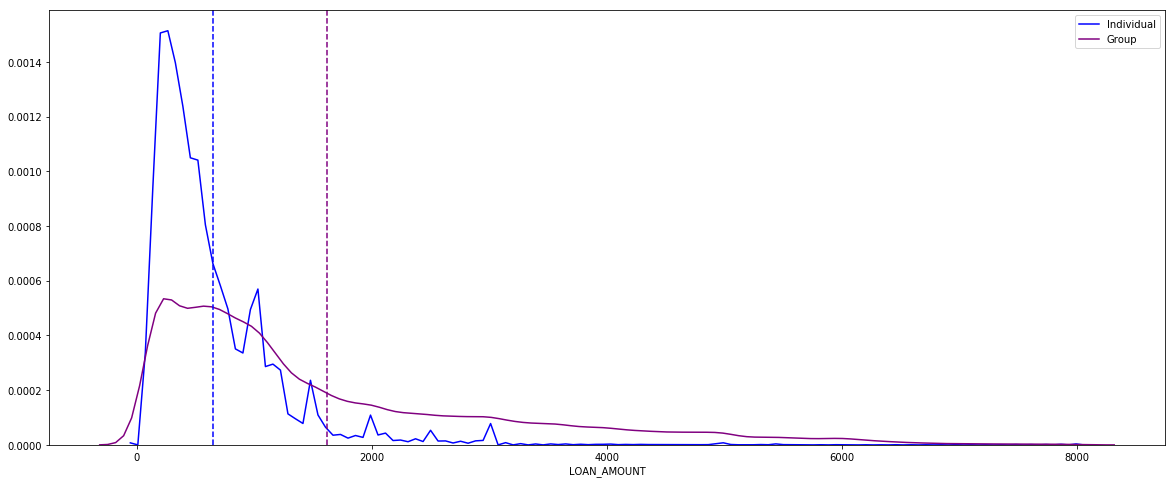

In [122]:
# Distribution by group
plt.figure(figsize=(20,8))
sns.distplot(df[individual]['LOAN_AMOUNT'], hist=False, color='blue', label = 'Individual', kde_kws={'clip': (0, 8000)})
sns.distplot(df[group]['LOAN_AMOUNT'], hist=False, color='purple', label = 'Group',  kde_kws={'clip': (0, 8000)})
plt.axvline(df[individual]['LOAN_AMOUNT'].mean(), color="blue", linestyle="--")
plt.axvline(df[group]['LOAN_AMOUNT'].mean(), color="purple", linestyle="--")

plt.legend();

In [56]:
# HYPOTHESIS TESTING FOR DIFFERENCES IN AVERAGE LOAN SIZES
# H0: mu_group - mu_individual = 0
# Ha: mu_group - mu_induvidual != 0

# alpha = 0.05

# T test
t, p = sts.ttest_ind(df[individual]['LOAN_AMOUNT'], df[group]['LOAN_AMOUNT'], equal_var=False)

# p value
print("p-value: {:2.2f}".format(p))

p-value: 0.00


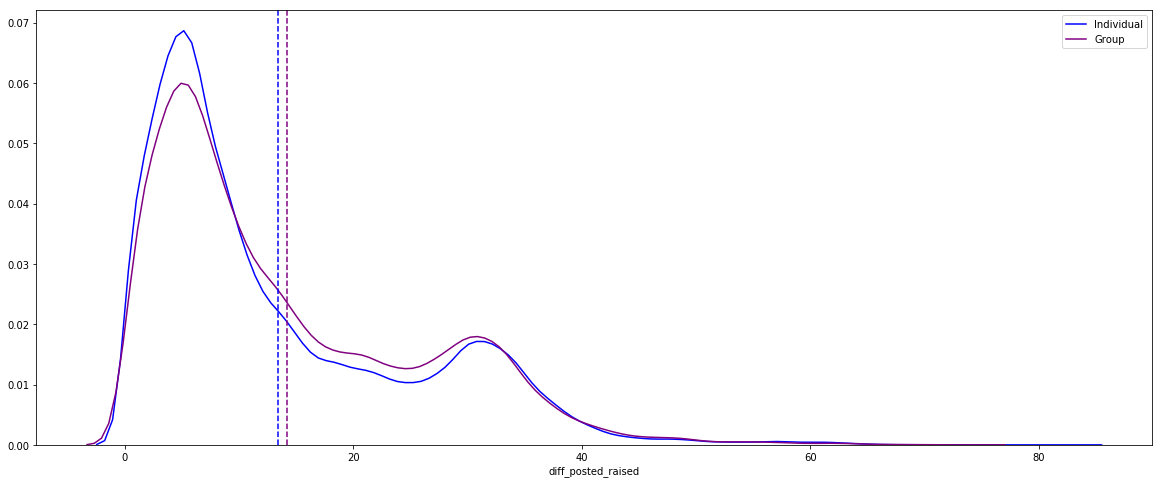

In [82]:
# Distribution by group

# Clean out weird data (we found some observations where the planned date was roughly one year appart from the posted date, which suggests data entry mistakes)
right_data = df['diff_posted_planned'] > -30

plt.figure(figsize=(20,8))
sns.distplot(df[individual & funded & right_data]['diff_posted_raised'], hist=False, color='blue', label = 'Individual')#, kde_kws={'clip': (-100, 100)})
sns.distplot(df[group  & funded & right_data]['diff_posted_raised'], hist=False, color='purple', label = 'Group')#,  kde_kws={'clip': (-100, 100)})
plt.axvline(df[individual  & funded & right_data]['diff_posted_raised'].mean(), color="blue", linestyle="--")
plt.axvline(df[group  & funded & right_data]['diff_posted_raised'].mean(), color="purple", linestyle="--")

plt.legend();

In [84]:
# HYPOTHESIS TESTING FOR DIFFERENCES IN AVERAGE TIME TO BE FUNDED
# H0: mu_group - mu_individual = 0
# Ha: mu_group - mu_induvidual != 0

# alpha = 0.05

# T test
funded = df['STATUS']=='funded'
t, p = sts.ttest_ind(df[individual & funded & right_data]['diff_posted_raised'], df[group & funded & right_data]['diff_posted_raised'], equal_var=False)

t, p
# p value
# print("p-value: {:2.2f}".format(p))

(-24.629323783868166, 8.828498401211112e-134)

## Gender differences for individual loans

### Are there gender differences by loan amount and time it takes to fund a loan?

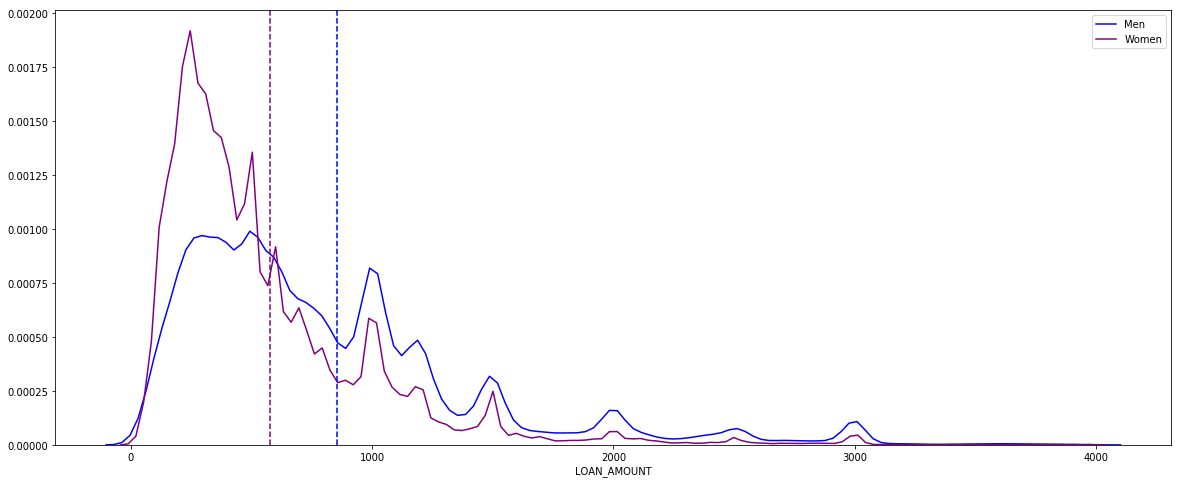

In [89]:
# Individual loan splitup by gender
male = df['BORROWER_GENDERS']=='male'
female = df['BORROWER_GENDERS']=='female'

plt.figure(figsize=(20,8))
sns.distplot(df[male]['LOAN_AMOUNT'], hist=False, color='blue', label = 'Men', kde_kws={'clip': (0, 4000)});
sns.distplot(df[female]['LOAN_AMOUNT'], hist=False, color='purple', label = 'Women', kde_kws={'clip': (0, 4000)});
plt.axvline(df[male]['LOAN_AMOUNT'].mean(), color="blue", linestyle="--")
plt.axvline(df[female]['LOAN_AMOUNT'].mean(), color="purple", linestyle="--")
plt.legend();

In [120]:
# H0: mu_male - mu_female = 0
# Ha: mu_male - mu_female != 0

# alpha = 0.05

# T test
t, p = sts.ttest_ind(df[male]['LOAN_AMOUNT'], df[female]['LOAN_AMOUNT'], equal_var=False)

# p value
print("p-value: {:2.2f}".format(p))

p-value: 0.00


/Users/nreyna/miniconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/nreyna/miniconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


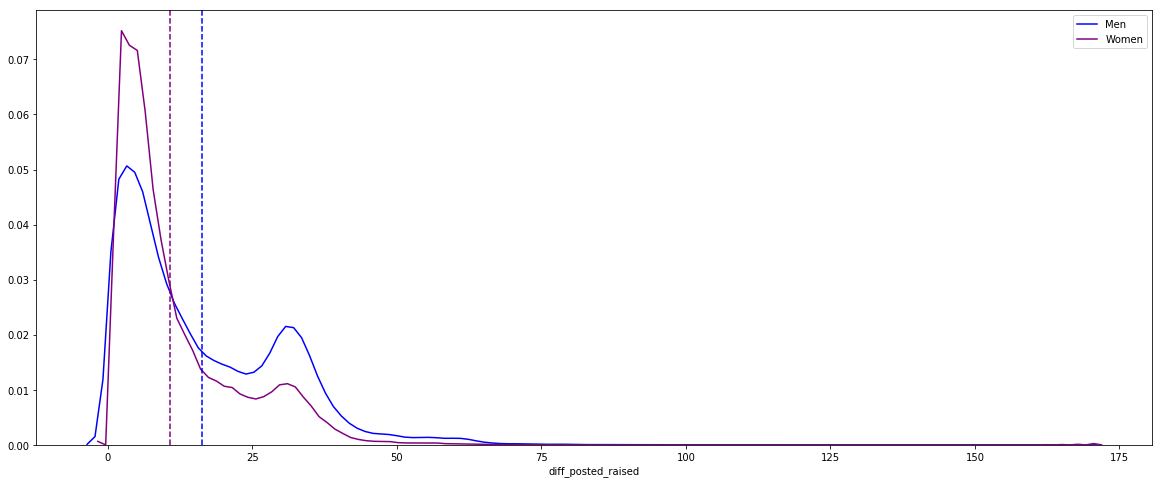

In [123]:

plt.figure(figsize=(20,8))
sns.distplot(df[male]['diff_posted_raised'], hist=False, color='blue', label = 'Men', kde_kws={'clip': (0, 4000)});
sns.distplot(df[female]['diff_posted_raised'], hist=False, color='purple', label = 'Women', kde_kws={'clip': (0, 4000)});
plt.axvline(df[male]['diff_posted_raised'].mean(), color="blue", linestyle="--")
plt.axvline(df[female]['diff_posted_raised'].mean(), color="purple", linestyle="--")
plt.legend();

### Is there a significant difference in the time it took to get a loan funded depending on whether the borrower is male or female, by sector?

In [95]:
# Step 1: State the null and alternative hypotheses
# H0: mu_male - mu_female = 0
# Ha: mu_male - mu_female != 0

# Step 2: Significance level: 
alpha = 0.05

# Steps 3 and 4: Compute t-tests and p-values
d = {}
for sector in set(df['SECTOR_NAME']):
    t, p = sts.ttest_ind(df[male & funded & right_data & (df['SECTOR_NAME'] == sector)]['diff_posted_raised'], df[female & funded & right_data & (df['SECTOR_NAME'] == sector)]['diff_posted_raised'], equal_var=False)
    d[sector] = [(p <= alpha/2)]
    d[sector].append(t)
d

# Step 5: Compare the p-value to alpha and decide.
# True: reject H0 that there is no difference between men and women.

{'Clothing': [True, 24.57360084050679],
 'Services': [True, 40.81881248506724],
 'Agriculture': [True, 113.94431307834792],
 'Retail': [True, 71.10347423553718],
 'Wholesale': [True, 9.67228366099994],
 'Manufacturing': [True, 18.31288765585262],
 'Entertainment': [True, 7.143310876396597],
 'Food': [True, 79.86007129343609],
 'Arts': [True, 3.9063862915706324],
 'Personal Use': [True, 28.321382420336754],
 'Housing': [True, 54.854574827102454],
 'Education': [True, 68.74727162314623],
 'Health': [True, 16.722846903237205],
 'Transportation': [True, 26.78656569692406],
 'Construction': [True, 23.38357565723308]}

### Cool finding: 
**Loans requested by women are fulfilled significantly faster than loans requested by men across all sectors. Is there lender bias towards women?**

In [145]:
# Step 1: State the null and alternative hypotheses
# H0: p_male - p_female = 0
# Ha: p_male - p_female != 0

# Step 2: Significance level: 
alpha = 0.05

t, p = sts.ttest_ind(df[male & funded & right_data]['VIDEO_ID'], df[female & funded & right_data]['VIDEO_ID'], equal_var=False)

t,p
# Steps 3 and 4: Compute t-tests and p-values
# d = {}
# for sector in set(df['SECTOR_NAME']):
#     t, p = sts.ttest_ind(df[male & funded & right_data & (df['SECTOR_NAME'] == sector)]['IMAGE_ID'], df[female & funded & right_data & (df['SECTOR_NAME'] == sector)]['IMAGE_ID'], equal_var=False)
#     d[sector] = [(p <= alpha/2)]
#     d[sector].append(t)
# d

# Step 5: Compare the p-value to alpha and decide.
# True: reject H0 that there is no difference between men and women.

(6.894642799656011, 5.414424687233542e-12)

## df[male]['VIDEO_ID'].mean()

In [144]:
df[female]['VIDEO_ID'].mean()

0.0003164762399376785

### Is there a significant difference in the average loan amount between male and female, by country?

In [119]:
# Step 1: State the null and alternative hypotheses
# H0: mu_male - mu_female = 0
# Ha: mu_male - mu_female != 0

# Step 2: Significance level: 
alpha = 0.05

# Steps 3 and 4: Compute t-tests and p-values
d = {}
for country in set(df['COUNTRY_NAME']):
    t, p = sts.ttest_ind(df[male & (df['COUNTRY_NAME'] == country)]['LOAN_AMOUNT'], df[female & (df['COUNTRY_NAME'] == country)]['LOAN_AMOUNT'], equal_var=False)
    d[country] = [(p <= alpha/2)]
    d[country].append(t)

/Users/nreyna/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/nreyna/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [109]:
counter_men_funded_then_women = 0
total = 0
for k,v in d.items():
    if v[0]==True:
        print(f'{k}:{v[1]}')
        total +=1
        if v[1]>0:
            counter_men_funded_then_women+=1

print('Number of countries where there is NO significant difference between amounts lent to men and women: ',len(d)-total)
print('Number of countries where there is a significant difference between amounts lent to men and women: ',total)
print('Number of countries where men get larger amounts than women: ',counter_men_funded_then_women)
print('Number of countries where women get larger amounts than men: ',total-counter_men_funded_then_women)

# Step 5: Compare the p-value to alpha and decide.
# True: reject H0 that there is no difference between men and women.

Ghana:2.5524752362305754
Peru:15.240438674676641
Honduras:5.92926543646266
Palestine:-10.311635759176573
Mexico:6.577638415042034
Indonesia:13.025646821804427
Egypt:14.498695326760519
Kyrgyzstan:-4.7057654383518575
Myanmar (Burma):6.115530211142076
Mongolia:3.146817357381388
Ecuador:-6.047972762799776
Burkina Faso:6.675858988238828
Kosovo:2.953353894472934
Liberia:28.655903484880287
South Africa:2.371806205755515
Haiti:5.995842116888868
Paraguay:9.182289431781387
Rwanda:5.866850918273524
Jordan:4.623152901451522
South Sudan:18.057854954733656
Benin:2.3012020841462784
Pakistan:50.65724537900572
Georgia:10.12237323994257
Cambodia:5.2971074375804585
Tanzania:4.327357072592714
Sierra Leone:26.63553812041567
Kenya:19.060581463919267
El Salvador:8.705594010278261
Suriname:3.4161457427604445
Togo:50.17091225630051
Ukraine:9.33607136502912
Philippines:26.844819450744115
Thailand:2.817940173099686
Colombia:5.8102811508785885
Malawi:3.1634373086815435
Uganda:29.269976916102742
Costa Rica:-8.2514

### Findings:
1. In roughly half of the countries in the dataset there is a significant inequality in the lent amounts across gender.
2. For countries where there is a significant difference in the average loan amount between men and women, roughly one in five times this difference is in favor of men.

### Question: Is there gender inequality in access to microfinance?
Possible approach to a response: Assuming the average loan amounts are a viable proxy for gender inequality in micro-finance, we can run t-tests to see if there are significant differences between men and women's average individual loan amount by country.

## More EDA to look for other interesting questions...

In [ ]:
# Count Plot by Sector
plt.figure(figsize=(15,4))
sns.countplot(x='SECTOR_NAME', data=df, orient='h', order = df['SECTOR_NAME'].value_counts().index)
plt.xticks(rotation='vertical')
plt.ylabel('Number of loans')
plt.xlabel('Sector Name')
plt.title("Number of Loans By Sector");

In [ ]:
# Calculate correlations
# df[['SECTOR_NAME', 'COUNTRY_NAME']]

# Heatmap

def count_rows(x):
    return len(x)

g = df.groupby(['SECTOR_NAME','COUNTRY_NAME']).apply(count_rows).unstack()
plt.figure(figsize=(16,4))
sns.heatmap(g, cmap='Blues', linewidth=0.5);

In [ ]:
# By Activity
df['ACTIVITY_NAME'].value_counts(1).head(10)

## Model: Field Partners vs. Direct

In [ ]:
# Field Partners
plt.figure(figsize=(16,8))
sns.boxplot(x='COUNTRY_NAME', y='LOAN_AMOUNT', data=df[df['DISTRIBUTION_MODEL']=='field_partner'])
plt.xticks(rotation='vertical')
plt.ylim(0,10000);

In [ ]:
# Direct
plt.figure(figsize=(8,4))
sns.boxplot(x='COUNTRY_NAME', y='LOAN_AMOUNT', data=df[df['DISTRIBUTION_MODEL']=='direct'])
plt.xticks(rotation='vertical');
plt.ylim(0,10000);

In [ ]:
g_country = df.groupby('COUNTRY_NAME')
g_country['LOAN_AMOUNT'].sum().sort_values(ascending=False).head(10)

In [ ]:
df.sort_values?

In [ ]:
import seaborn as sns
corr = df[['LOAN_AMOUNT', 'LENDER_TERM', 'NUM_LENDERS_TOTAL', 'GROUP']].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           cmap='Blues')

In [ ]:
df[male].describe().T

In [ ]:
df[female].describe().transpose()

In [ ]:
g = sns.lmplot(x="LOAN_AMOUNT", y="NUM_LENDERS_TOTAL", hue = 'BORROWER_GENDERS',
               truncate=True, size=8, data=df[individual])
g.set_axis_labels("Loan Size", "Number of Lenders");

In [ ]:
g = sns.lmplot(x="LOAN_AMOUNT", y="NUM_LENDERS_TOTAL", hue='GROUP',
               truncate=True, size=5, data=df)
g.set_axis_labels("Loan Size", "Number of Lenders");

Other questions?